# Original procedure outline

The original procedure consists from the following steps:

1. Constructing reference from bulk methylation dataset;
2. Intersection of sites from sc-methylation data with presented in the reference dataset;
3. Filtering the sites with good correlation between methylation and age;
4. Getting probabilities of each site to be methylated;
5. Truncating probabilites if needed;
6. Estimation maximum likelihood function for different values of ages (where ages are chosen from the uniform grid);
7. Finding the age value maximizing log-likelihood.

![](figures/procedure.png)

# Mathematical formulation

Problem of **single cell** age inference is reduced to the maximum likelihood estimation problem, namely:

$$ y^* = \argmax_y \prod_{i=1}^n p_i(y) \tag{1}$$

where $y$ - sought cell age and $y^*$ - optimal cell age correspondingy; $p_i(y)$ - probability of $i$-th CpG site to be methylated; $n$ - total number of sites. Authors proposed to use a concrete functional form for the probabilities:

$$ p_i(y) = p_i(y|b_i, w_i) = w_{i}y + b_i \tag{2}$$

the weight $w_i$ and bias $b_i$ are taken from a reference bulk dataset. Importantly these weights and biases are not the result of ElasticNet model fitting to predict age but Linear Regression model was fitted for each site separately. Specifically, for each $i$-th methylation site having methylation value $x_i \in [0,1]$ the following problem was solved:

$$ w_i,b_i = \argmin_{w, b} ||x_i - wy - b||_2^2$$

Thus, weights and biases, obtained after multiple regression models fitting on bulk dataset, were applied to predict cell age in the single cell dataset. Combining the equations (1) and (2) have:

$$ y^* = \argmax_y \prod_{i=1}^n (w_{i}y + b_i) \tag{3}$$

The objective (3) is not a whole procedure of cell age inference. Two problems have to be resolved before: 
1. Probability values are not bounded in the proposed linear function approximation;
2. The probabilites are not conditioned by the concrete single cell methylation profile.

For the first problem authors proposed to bound a linear function by a manually predetermined constants, e.g.:
\begin{align*} 
    if\ p \geq 1 \rightarrow p = 1 - \epsilon \\
    if\ p \leq 0 \rightarrow p = \epsilon 
\end{align*}
where $\epsilon$ is small constant typically equal to $0.001$. This bounding generates one of the main **problem** with the whole procedure which we discuss below in details within this notebook.

For the second problem authors proposed to use the following conditioning on single cell methylation profile for the probabilities by modifying equation (2):

$$ p_i(y) = p_i(y|b_i, w_i, CpG_i) = p_i^{CpG_i}(1-p_i)^{1-CpG_i} = 
\begin{bmatrix}
w_{i}y + b_i, |\ CpG_i = 1 \\
-w_{i}y + (1-b_i), |\  CpG_i = 0
\end{bmatrix} \tag{4}$$

where $CpG_i$ can take values from ${0, 1}$ based on the actual observation of single cell methylation data. The idea of the preconditionin is just to consider a probability of inverse event if zero value of methylation was observed in data. By substitution the expression (4) to the objective (1) one can observe that for each concrete cell the problem is reduced to the finding a maximum of polynomial function on the interval:

$$ y^* = \argmax_{y\in [y_{min}, y_{max}]} \prod_{i=1}^n p_i(y|CpG) = 
        (w_{1}y + b_1)(-w_{2}y + (1-b_2))\cdots (w_{n}y + b_n); for\ CpG = [1,0,...1]
\tag{5}$$

Authors solve this problem by brute force approach, i.e. they split the interval of search ($[y_{min}, y_{max}]$) into $K$ number of ages and estimate the likelihood function in each point of the grid. This approach might be robust in case you would have 1-5 CpG cites but in reality this generates the second main **problem** of the whole procedure which, I argue, leads to the wrong coclusion about **ground zero** existence.

Below I propose to consider the corrected procedure which avoids splitting the interval of search into K uniformly distributed values. Instead, I find global maximum of likelihood function on the interval by definition using nice properties of polynomial function. Moreover, I show that procedure of bounding probabilities leads to wrong results in case we expand the interval of search to the negative ages (what was done in the original paper) - I show how we can define this interval automatically based on the properties of monomials of the polynomial function.

In [24]:
import numpy as np
from scipy.stats import spearmanr, logistic, t as tstat
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from glob import glob
import os
import h5py
pd.set_option('display.max_columns', 150)

# Problems with the procedure

## Explore the original procedure

### Artificial data

In [34]:
#get weights from real clocks (from the first step)
clocks = pd.read_csv('clock_data/Thompson_Multi_BL6.tsv', sep='\t', index_col=0)
method, alpha = 'bonferroni', 0.01
n_corrected_sites = clocks['PearsonP'][multipletests(clocks['PearsonP'], method=method, alpha=alpha)[0]].shape[0]
print(f'Survived after {method} correction {n_corrected_sites} sites at s.level={alpha}')

#get top n from them based on the absolute value of correlation
top = 300
top_idx = clocks['PearsonR'].abs().sort_values(ascending=False)[:top].index
top_sites = clocks.loc[top_idx]

#get weights and biases
w_ = np.asarray(top_sites['Coef'])
b_ = np.asarray(top_sites['Intercept'])
roots_ = -b_ / w_ #polynomial roots before single cell data

# make an artificial signle cell methylation data (sampled from binomial distribution)
p_nonmet = 0.5
mask = np.random.binomial(1, p=p_nonmet, size=top).astype(bool)

#change weights and biases based on 0 or 1 in methylation data (apply -1 if 0)
w = np.array([-wi if m==False else wi for m, wi in zip(mask, w_)])
b = np.array([1-bi if m==False else bi for m, bi in zip(mask, b_)])
roots = -b / w #polynomial roots after single cell data

print('Correlation weights and biases before data', np.round(np.corrcoef(w_, b_)[0,1], 3))
print('Correlation weights and biases after data', np.round(np.corrcoef(w, b)[0,1], 3))

Survived after bonferroni correction 247 sites at s.level=0.01
Correlation weights and biases before data -0.519
Correlation weights and biases after data -0.517


In [3]:
top_sites.head()

,PearsonR,PearsonP,Coef,Intercept
ChrPos,,,,
chr8_125670043,0.550696,6.153575e-17,0.007300,0.011504
chr17_50293058,0.534526,7.071041e-16,0.003155,0.022224
chr5_146461718,-0.529279,1.794865e-15,-0.012873,0.558959
chr6_31079744,-0.526267,2.342072e-15,-0.013723,0.526372
chr15_73814059,-0.524342,4.271947e-15,-0.012167,0.400363


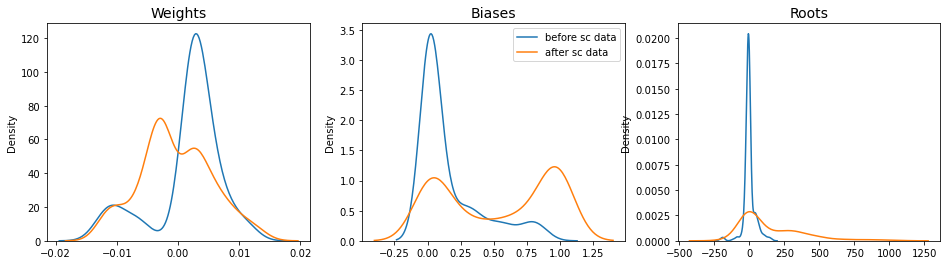

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].set_title('Weights', fontsize=14)
sns.kdeplot(w_, label='before sc data', ax=axes[0])
sns.kdeplot(w, label='after sc data', ax=axes[0])

axes[1].set_title('Biases', fontsize=14)
sns.kdeplot(b_, label='before sc data', ax=axes[1])
sns.kdeplot(b, label='after sc data', ax=axes[1])

axes[2].set_title('Roots', fontsize=14)
sns.kdeplot(roots_, label='before sc data', ax=axes[2])
sns.kdeplot(roots, label='after sc data', ax=axes[2])

axes[1].legend()
plt.show()

* if left boundary of site > right boundary of search interval, $p \approx 1$
* if right boundary of site < left boundary of search interval, $p \approx 0$

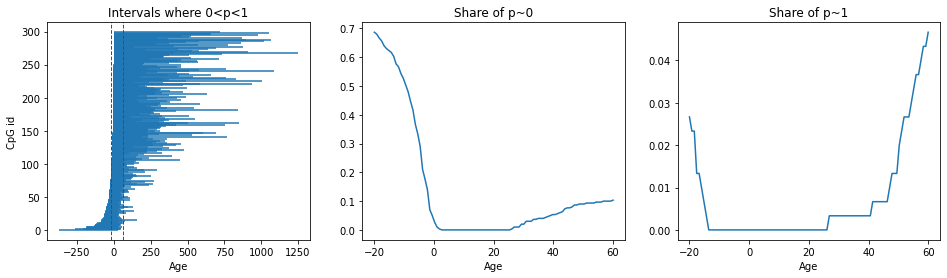

In [5]:
interval_of_search = (-20, 60)

x_intervals = np.array([[-bi/wi if -bi/wi < (1-bi)/wi else (1-bi)/wi for bi, wi in zip(b_, w_)], 
                        [(1-bi)/wi if -bi/wi < (1-bi)/wi else -bi/wi for bi, wi in zip(b_, w_)],]).T
sorted_intervals = x_intervals[np.argsort(x_intervals[:, 0])]

x = np.linspace(interval_of_search[0], interval_of_search[1], 100)
share_of_p0 = []
share_of_p1 = []
for xi in x:
    p = w_ * xi + b_
    share_of_p0.append((p < 0).sum() / p.shape[0])
    share_of_p1.append((p > 1).sum() / p.shape[0])

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, (xmin, xmax) in enumerate(sorted_intervals):
    axes[0].hlines(i, xmin, xmax)
axes[0].axvline(interval_of_search[0], lw=1, ls='--', color='red')
axes[0].axvline(interval_of_search[1], lw=1, ls='--', color='red')
axes[0].set_title('Intervals where 0<p<1')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('CpG id');

axes[1].plot(x, share_of_p0)
axes[2].plot(x, share_of_p1)
axes[1].set_title('Share of p~0')
axes[2].set_title('Share of p~1')
axes[1].set_xlabel('Age')
axes[2].set_xlabel('Age');

In [8]:
n_steps = 100
m_cells = 100
interval_of_search = (-20, 60)
# eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
# interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
one_met_replacement = 0.999
zero_met_replacement = 0.001

probs = np.zeros((m_cells, n_steps))
x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'p':[]})
for p_met in np.linspace(0, 1.0, 12):
    for cell in range(m_cells):
        mask = np.random.binomial(1, p=p_met, size=top).astype(bool)
        for i, xi in enumerate(x):
            p = w_ * xi + b_
            p[p <= 0] = zero_met_replacement
            p[p >= 1] = one_met_replacement
            p = np.where(mask, p, 1-p)
            probs[cell, i] = np.log(p).sum()

    x_opt = np.array([x[i] for i in np.argmax(probs, axis=1)])
    data = pd.concat([data, pd.DataFrame({'Ages':x_opt, "p":round(p_met, 2)})])

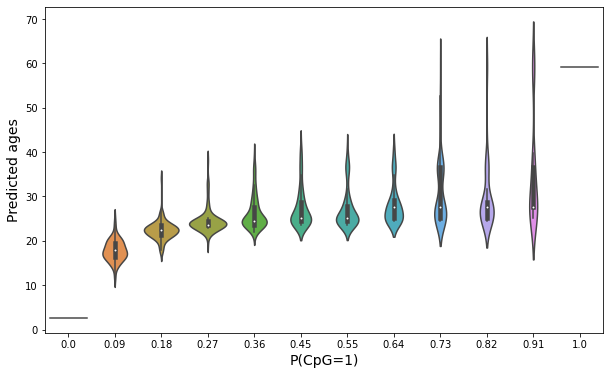

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.violinplot(x='p', y='Ages', data=data, ax=axes)
axes.set_xlabel('P(CpG=1)', fontsize=14)
axes.set_ylabel('Predicted ages', fontsize=14);

### Real data

In [10]:
meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
meta['stage'] = meta['characteristics_ch1.1.developmental stage']
stages = sorted(meta['stage'].unique().tolist())
list_cells = glob('cell_data/cells/*.h5')

######
interval_of_search = (-20, 60) #CUSTOM INTERVAL IN SCOPE
######

x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        path = f'cell_data/cells/{cell_name}.h5'
        assert os.path.exists(path)
        cell_df = pd.read_hdf(path)
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        if len(common_sites) == 0:
            continue
        
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites][cell_name].values
        probs = []
        for i, xi in enumerate(x):
            p = w_ * xi + b_
            p[p <= 0] = zero_met_replacement
            p[p >= 1] = one_met_replacement
            p = np.where(mask, p, 1-p)
            probs.append(np.log(p).sum())
        cell_ages.append(x[np.argmax(probs)])
        n_common_sites.append(len(common_sites))
        methyl_prob.append(np.mean(mask))
        methyl_prob_cell.append(np.mean(cell_df[cell_name]))
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])

100%|██████████| 296/296 [02:04<00:00,  2.38it/s]


In [11]:
data.groupby('Stage').mean()

,Ages,n_sites,p_empiric,p_empiric_full_cell
Stage,,,,
E4.5,-0.472552,7.695652,0.083583,0.271127
E5.5,-8.282828,8.567797,0.157293,0.686452
E6.5,-6.126323,11.801205,0.174195,0.738263
E7.5,-9.566924,10.748988,0.138978,0.726148


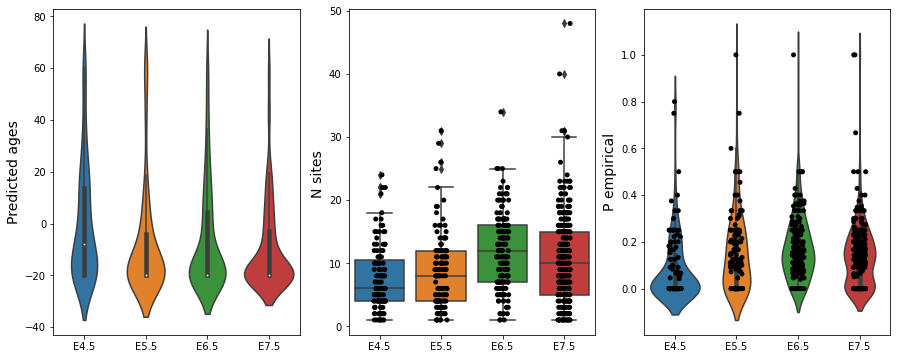

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);

In [14]:
meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
meta['stage'] = meta['characteristics_ch1.1.developmental stage']
stages = sorted(meta['stage'].unique().tolist())
list_cells = glob('cell_data/cells/*.h5')

#PROPER INTERVAL IN SCOPE
eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
############

x = np.linspace(interval_of_search[0], interval_of_search[1], n_steps)
data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        path = f'cell_data/cells/{cell_name}.h5'
        assert os.path.exists(path)
        cell_df = pd.read_hdf(path)
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        if len(common_sites) == 0:
            continue
        
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites][cell_name].values
        probs = []
        for i, xi in enumerate(x):
            p = w_ * xi + b_
            p[p <= 0] = zero_met_replacement
            p[p >= 1] = one_met_replacement
            p = np.where(mask, p, 1-p)
            probs.append(np.log(p).sum())
        cell_ages.append(x[np.argmax(probs)])
        n_common_sites.append(len(common_sites))
        methyl_prob.append(np.mean(mask))
        methyl_prob_cell.append(np.mean(cell_df[cell_name]))
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])

100%|██████████| 296/296 [02:00<00:00,  2.46it/s]


In [16]:
data.groupby('Stage').mean()

,Ages,n_sites,p_empiric,p_empiric_full_cell
Stage,,,,
E4.5,8.015055,7.695652,0.083583,0.271127
E5.5,5.170758,8.567797,0.157293,0.686452
E6.5,6.445602,11.801205,0.174195,0.738263
E7.5,4.984699,10.748988,0.138978,0.726148


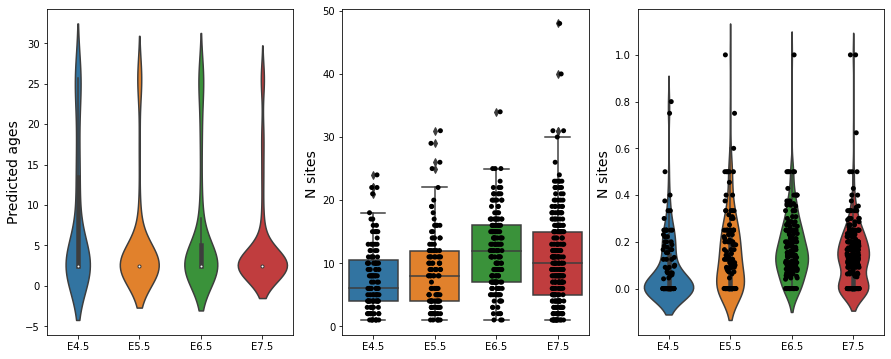

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('N sites ', fontsize=14);

# Correct procedure

In [19]:
from scipy.optimize import fsolve
import numpy as np

def get_max(w, b, domain=None, verbose=0):
    """
    docs
    """
    roots = -b / w
    ord = 'even' if (len(roots) % 2) == 0 else 'odd'
    sign = np.prod(np.sign(w))
    roots = np.sort(roots)
    domain = [roots[0], roots[-1]] if domain is None else domain

    ff = lambda x: np.prod([(wi*x + bi) for wi, bi in zip(w, b)])
    #logf = lambda x: sum([np.log(wi*x + bi) for wi, bi in zip(w, b)])
    df = lambda x: sum([wi/(wi*x + bi) for wi, bi in zip(w, b)])

    if (ord == 'even') and (sign > 0): #first root left from min; last root right from min
        pairs = roots[1:-1].reshape(-1, 2).tolist()
    elif (ord == 'even') and (sign < 0): #first root left from max; last root right from max
        pairs = roots.reshape(-1, 2).tolist()
    elif (ord == 'odd') and (sign > 0): #first root left from max; last root right from min
        pairs = roots[:-1].reshape(-1, 2).tolist()
    elif (ord == 'odd') and (sign < 0): #first root left from min; last root right from max
        pairs = roots[1:].reshape(-1, 2).tolist()

    maxroots = []
    for pair in pairs:
        if (pair[0] >= domain[0]) and (pair[1] <= domain[1]):
            root = fsolve(df, np.mean(pair))[0]
        else:
            continue
        maxroots.append(root)
    
    maxroots = [domain[0]] + maxroots + [domain[1]]
    solution = maxroots[np.argmax([ff(m) for m in maxroots])]
    if verbose > 0:
        if (solution == maxroots[0]):
            print('Solution on the start of the interval!')
        elif solution == maxroots[-1]:
            print('Solution on the end of the interval!')
        else:
            pass
    return solution

### Artificial data

In [21]:
m_cells = 100
w_ = np.asarray(top_sites['Coef'])
b_ = np.asarray(top_sites['Intercept'])

eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
print("Correct interval:", interval_of_search)

data = pd.DataFrame({'Ages':[], 'p':[]})
for p_met in np.linspace(0, 1.0, 12):
    x_opt = np.zeros(m_cells)
    for cell in range(m_cells):
        mask = np.random.binomial(1, p=p_met, size=top).astype(bool)
        w = np.where(mask, w_, -w_)
        b = np.where(mask, w_, 1-b_)
        x_opt[cell] = get_max(w, b, domain=interval_of_search, verbose=0)

    data = pd.concat([data, pd.DataFrame({'Ages':x_opt, "p":round(p_met, 2)})])

Correct interval: (2.525556585750046, 25.707286335607854)


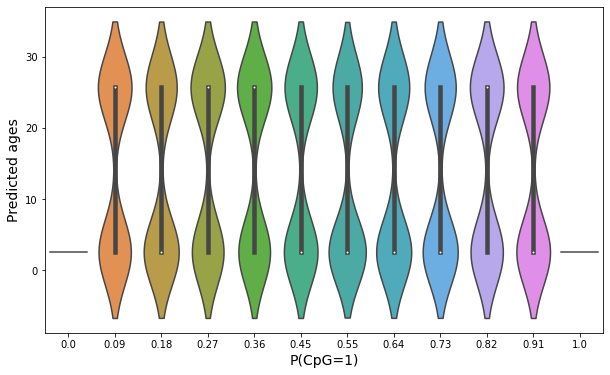

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.violinplot(x='p', y='Ages', data=data, ax=axes)
axes.set_xlabel('P(CpG=1)', fontsize=14)
axes.set_ylabel('Predicted ages', fontsize=14);

### Real data

In [26]:
meta = pd.read_csv('cell_data/GSE121690_metadata.csv', index_col=0)
meta['stage'] = meta['characteristics_ch1.1.developmental stage']
stages = sorted(meta['stage'].unique().tolist())
list_cells = glob('cell_data/cells/*.h5')

#PROPER INTERVAL IN SCOPE
eps = 0.01 #to not touch to the interval boundaries where p=0 or p=1
interval_of_search = (x_intervals[:, 0].max() + eps, x_intervals[:, 1].min() - eps)
############

data = pd.DataFrame({'Ages':[], 'Stage':[]})
for stage in stages:
    stage_cells = meta[meta['stage'] == stage].index
    cell_ages = []
    n_common_sites = []
    methyl_prob = []
    methyl_prob_cell = []
    for cell_name in tqdm(stage_cells):
        path = f'cell_data/cells/{cell_name}.h5'
        assert os.path.exists(path)
        cell_df = pd.read_hdf(path)
        common_sites = top_sites.index.intersection(cell_df.index).tolist()
        if len(common_sites) == 0:
            continue
        
        top_sites_sub = top_sites.loc[common_sites][['Coef', 'Intercept']]
        w_, b_ = top_sites_sub['Coef'].values, top_sites_sub['Intercept'].values
        mask = cell_df.loc[common_sites][cell_name].values
        w = np.where(mask, w_, -w_)
        b = np.where(mask, w_, 1-b_)
        predicted_age = get_max(w, b, domain=interval_of_search, verbose=0)
        
        cell_ages.append(predicted_age)
        n_common_sites.append(len(common_sites))
        methyl_prob.append(np.mean(mask))
        methyl_prob_cell.append(np.mean(cell_df[cell_name]))
    data = pd.concat([data, pd.DataFrame({'Ages':cell_ages, 
                                          'Stage':stage, 
                                          'n_sites': n_common_sites,
                                          'p_empiric': methyl_prob,
                                          'p_empiric_full_cell': methyl_prob_cell,
                                          })])

100%|██████████| 296/296 [02:03<00:00,  2.41it/s]


In [27]:
data.groupby('Stage').mean()

,Ages,n_sites,p_empiric,p_empiric_full_cell
Stage,,,,
E4.5,7.968224,7.695652,0.083583,0.271127
E5.5,10.187315,8.567797,0.157293,0.686452
E6.5,11.183793,11.801205,0.174195,0.738263
E7.5,10.409222,10.748988,0.138978,0.726148


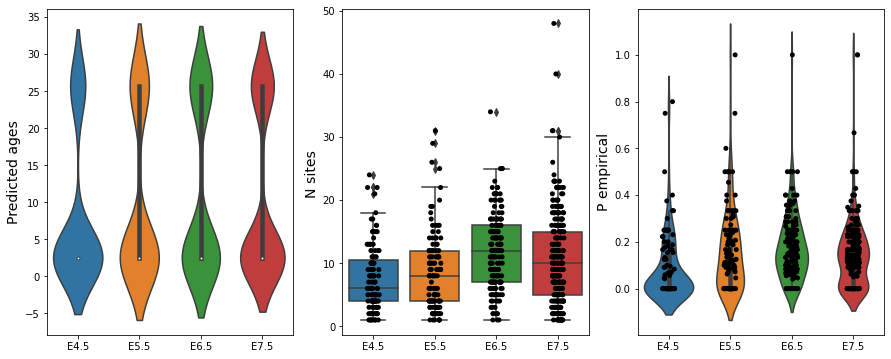

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
sns.violinplot(x='Stage', y='Ages', data=data, ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Predicted ages', fontsize=14);

sns.stripplot(x='Stage', y='n_sites', data=data, ax=axes[1], color='black')
sns.boxplot(x='Stage', y='n_sites', data=data, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('N sites ', fontsize=14);

sns.violinplot(x='Stage', y='p_empiric', data=data, ax=axes[2])
sns.stripplot(x='Stage', y='p_empiric', data=data, ax=axes[2], color='black')
axes[2].set_xlabel('')
axes[2].set_ylabel('P empirical', fontsize=14);

# Other

In [300]:
# from scipy.signal import argrelextrema

# # n = 20 #number of weights
# # w = np.random.randn(n)  # w \in R
# # b = np.random.randn(n)  # b > 0
# roots = -b / w

# ff = lambda x: np.prod([(wi*x + bi) for wi, bi in zip(w, b)])
# z = np.linspace(-100, 100, 1000)
# fz = [ff(zi) for zi in z]

# num_max = z[argrelextrema(np.array(fz), np.greater)[0]\
#     [np.argmax(np.array(fz)[argrelextrema(np.array(fz), np.greater)[0]])]]
# num_max = [z[0], num_max, z[-1]][np.argmax([ff(z[0]), ff(num_max), ff(z[-1])])]

# print(get_max(w, b, domain=[-100, 100]))
# print(num_max)

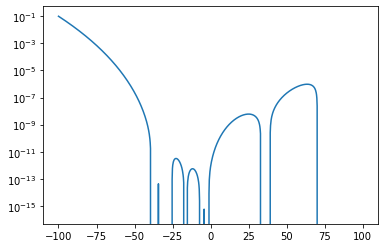

In [123]:
plt.semilogy(z, fz)

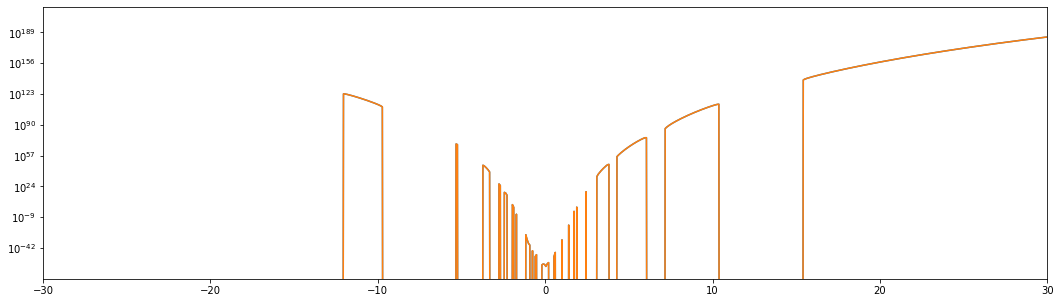

In [647]:
plt.figure(figsize=(18,5))
plt.semilogy(z, fz)
plt.plot(z, fz)
plt.xlim([-30, 30])
plt.eventplot(roots, color='red', lw=2)